In [1]:
import os
import json
import numpy as np
import pandas as pd

In [2]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(ztfredshifts["id"])))

In [3]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

In [4]:
lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}

In [5]:
# Initialize an empty dictionary to store non-empty items
flc_dict = {}
elc_dict = {}

# Iterate over the items in lc_dict
for key, value in lc_dict.items():
    # Check if the value is not empty
    if not value.empty:
        # If the value is not empty, add it to the new dictionary
        flc_dict[key] = value
    else:
        # If the value is empty, print the key
        print(f"{key}")
        elc_dict[key] = value

# Now non_empty_lc_dict contains only the items from lc_dict that are not empty

print('number of non-empty lightcurves:', len(flc_dict))
print('number of empty lightcurves:', len(elc_dict))

194.94985-47.75
Swift-J002325.5-141701
Swift-J181727.0-192921
ZTF18abfcmjwm
ZTF18abianhw
ZTF18abukavnm
ZTF18abvkwlam
ZTF19aankdan
ZTF19aapuudk
ZTF19aasexmy
ZTF19abeyvoi
ZTF19abobxik
ZTF19abrpfps
ZTF19abuvqgw
ZTF19acaxbjt
ZTF19acayojs
ZTF19accxzsc
ZTF20aaelulum
ZTF20aazrcbp
ZTF20ababxjv
ZTF20abmocba
ZTF20acigmelm
ZTF22abvvmti
number of non-empty lightcurves: 190
number of empty lightcurves: 23


In [6]:
## these are the candidates that I found to be rated a 4 or 5 on a 0-5 scale. see candidate eval spreadsheet for additional notes on each
best_cands = [
    "ZTF18aakuewf",
    "ZTF19aapfmki",
    "ZTF19aatesgp",
    "ZTF19abacxod",
    "ZTF19abxjrge",
    "ZTF19abyjzvd",
    "ZTF20aahfqpm",
    "ZTF20aakypiu",
    "ZTF20aaxhzhc",
    "ZTF20abwysqy",
    "ZTF20abwzqzo",
    "ZTF20acgigfo",
    "ZTF20acgiglu",
    "ZTF20aclfmwn",
    "ZTF20acozryr",
    "ZTF20actqnhg",
    "ZTF20acxouxk",
    "ZTF21aaabrpu",
    "ZTF21aabxjqr",
    "ZTF21aacxlgf",
    "ZTF21aajzfoq",
    "ZTF21aapkbav",
    "ZTF21abturbi",
    "ZTF21abuysnl",
    "ZTF21accyynu",
    "ZTF21aciosfu",
    "ZTF21acnjzwy",
    "ZTF22aaajecp",
    "ZTF22aaazhbd",
    "ZTF22aabvdtc",
    "ZTF22aahgvlx",
    "ZTF22aaigbnr",
    "ZTF22aajkkwd",
    "ZTF22aajrrzz",
    "ZTF22aanbmvf",
    "ZTF22aayluxo",
    "ZTF22aazmooy",
    "ZTF22abaowkz",
    "ZTF22abfxmpc",
    "ZTF22abntkbk",
    "ZTF22abtonmb",
    "ZTF22abuzpzz",
    "ZTF22abzucul",
    "ZTF23aaemgsd",
    "ZTF23aaenmcm",
    "ZTF23aaeozpp",
    "ZTF23aagunkc",
    "ZTF23aahnnrr",
    "ZTF23aaikakr",
    "ZTF23aaimsja",
    "ZTF23aaixebv",
    "ZTF23aajaxvk",
    "ZTF23aajazzg",
    "ZTF23aaljkky",
    "ZTF23aamibcp",
    "ZTF23aaoohpy",
    "ZTF23aarlxdf",
    "ZTF23aasxbqp",
    "ZTF23aauotrt",
    "ZTF23aavtwvs",
    "ZTF23abceaxk",
    "ZTF23abeqble",
    "ZTF23abgsmsg",
    "ZTF23abjwgre",
    "ZTF23abnpdod",
    "ZTF23abpxorf",
    "ZTF23absajre",
    "ZTF23absbqun",
    "ZTF24aafuvmu",
    "ZTF24aahkzvn"
]
bflc_dict = {key: value for key, value in flc_dict.items() if key in best_cands}

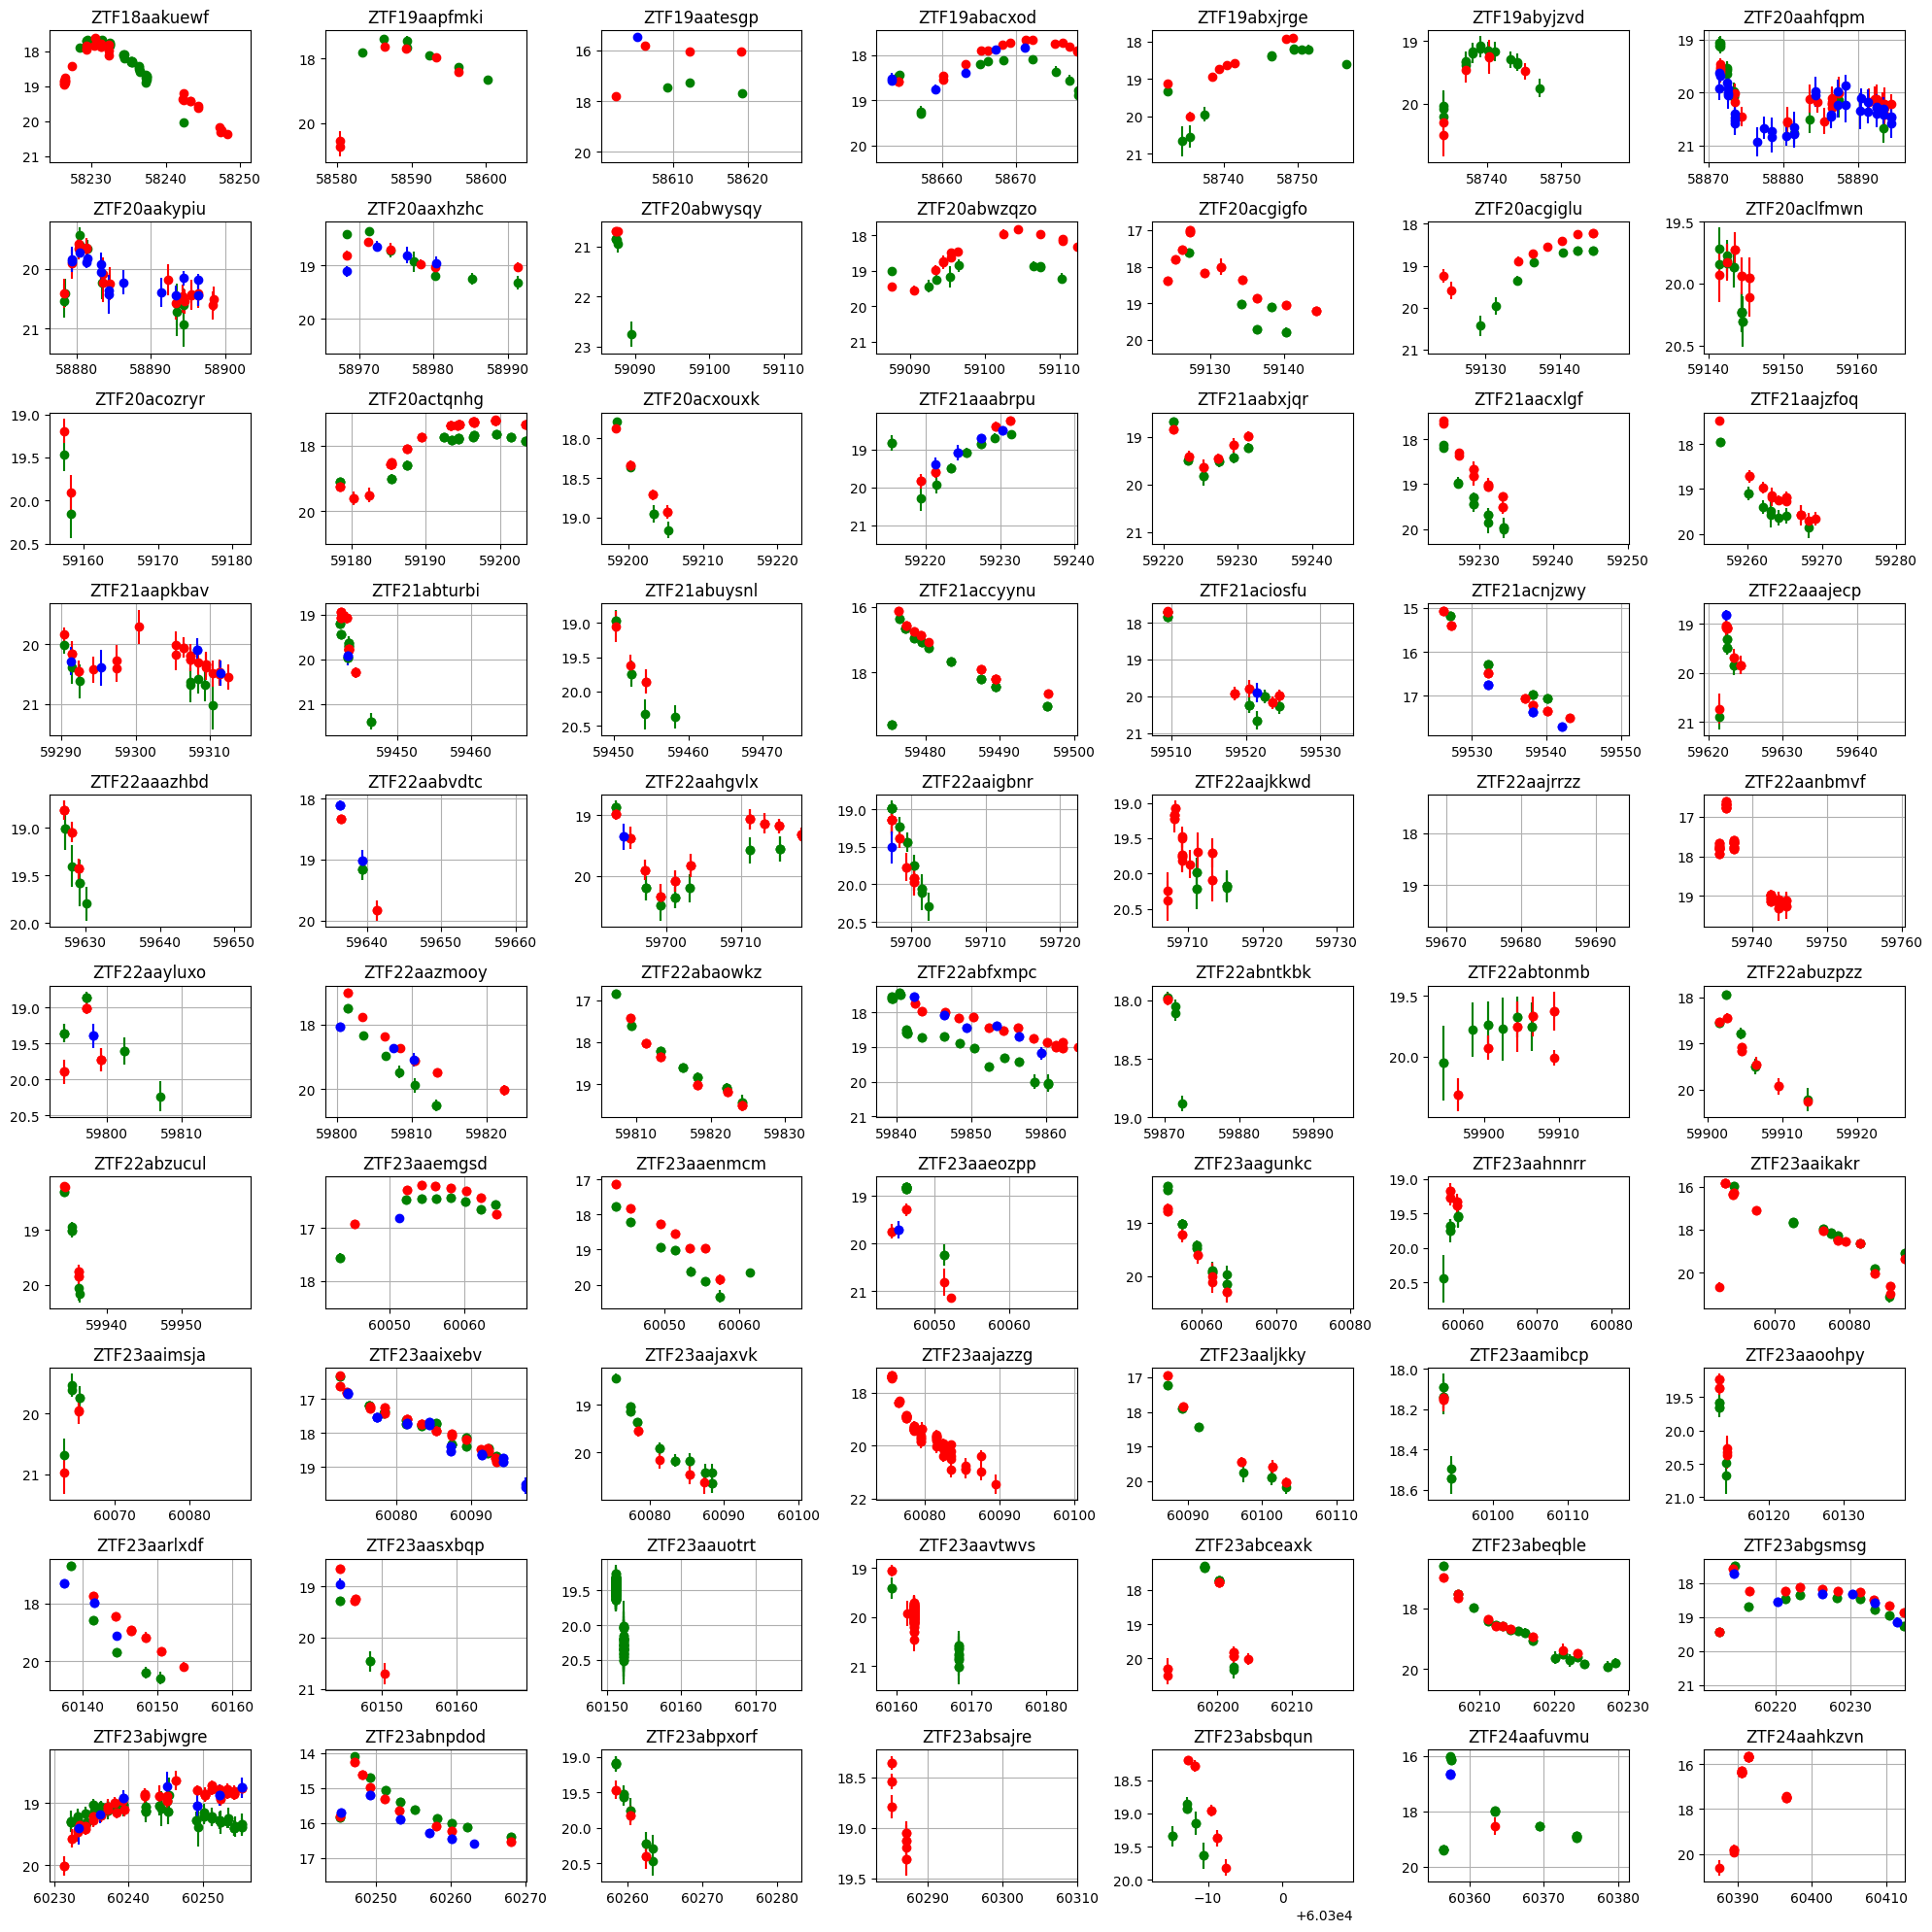

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10,7, figsize=(20, 20))
color = {'ztfg': 'g', 'ztfr': 'r', 'ztfi': 'b'}
for i, (key, value) in enumerate(bflc_dict.items()):
    ax = axs[i//7, i%7]
    min_time = value[(value['mag'].notnull())]['mjd'].min()
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        filt_df = value[(value['filter'] == filt)  & (value['mag'].notnull())]
        # ax.set_xlabel('MJD')
        # ax.set_ylabel('Magnitude')
        ax.set_title(f'{key}')
        ax.invert_yaxis()
        if filt_df.empty:
            continue
        # display(filt_df)
        ax.errorbar(filt_df['mjd'], filt_df['mag'], yerr=filt_df['magerr'], fmt='o', label=filt, color=color[filt])
        ax.grid()
        ax.set_xlim(min_time-2, min_time+25)
        # ax.legend()
        
fig.tight_layout()
plt.show()

In [9]:
df_eval = pd.read_csv('candidateEval05-30.csv')
df_eval.head()

,Object,Classification,Captures rise in g,captures fade in g,Captures rise in r,captures fade in r,Has i band?,ztfg rise min/max,ztfg fade min/max,ztfr rise min/max,ztfr fade min/max,ztfi rise min/max,ztfi fade min/max,usable? (0-5),Misc Notes
0,ZTF18aakuewf,NaN,n,y,y,y,n,NaN,58225-58240,58225-58230,58230-58250,NaN,NaN,4,NaN
1,ZTF18aalrxas,NaN,y,y,n,n,n,NaN,NaN,NaN,NaN,NaN,NaN,3,lowish quality ztfr
2,ZTF18abantmh,NaN,n,n,n,n,n,NaN,NaN,NaN,NaN,NaN,NaN,0,low quality
3,ZTF18abffyqp,NaN,n,m,n,m,n,NaN,NaN,NaN,NaN,NaN,NaN,1,no peak
4,ZTF18abvkmgw,NaN,y,y,n,n,n,NaN,NaN,NaN,NaN,NaN,NaN,3,decent g


In [7]:
## plot each of the best candidates in a 1x3 grid for each, where each column is a different filter. each plot should have the lightcurve labeled
import matplotlib.pyplot as plt

# for key, value in bflc_dict.items():
#     color = {'ztfg': 'g', 'ztfr': 'r', 'ztfi': 'b'}
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
#     for i, (ax, filt) in enumerate(zip(axs, ['ztfg', 'ztfr', 'ztfi'])):
#         filt_df = value[(value['filter'] == filt)  & (value['mag'].notnull())]
#         ax.set_xlabel('MJD')
#         ax.set_ylabel('Magnitude')
#         ax.set_title(f'{key}')
#         ax.invert_yaxis()
#         if filt_df.empty:
#             continue
#         # display(filt_df)
#         ax.errorbar(filt_df['mjd'], filt_df['mag'], yerr=filt_df['magerr'], fmt='o', label=filt, color=color[filt])
#         ax.grid()
#         ax.set_xlim(filt_df['mjd'].min()-5, filt_df['mjd'].min()+30)
#         ax.legend()
#     plt.tight_layout()
#     plt.show()
